<a href="https://colab.research.google.com/github/Shashwat17-vit/opencv/blob/master/TomatoCNNUnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import tensorflow.keras.backend as K
import tensorflow as tf

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, 'float32')  # Ensure y_true is float32
    y_pred = K.cast(y_pred, 'float32')  # Ensure y_pred is float32

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_images(image_dir, img_size=(1400, 875)):
    images = []

    image_files = sorted(os.listdir(image_dir))  # Ensure matching order with masks

    for img_file in image_files:
        # Load and preprocess the image
        img_path = os.path.join(image_dir, img_file)

        img = load_img(img_path, target_size=img_size)  # Resize image

        img = img_to_array(img) / 255.0  # Normalize image

        images.append(img)

    return np.array(images)

In [34]:
image_dir = "drive/MyDrive/Data/infected-tomato-leaf-vein-segmentation/train"
img_size = (1024, 1024)  # Input size for U-Net

images = load_images(image_dir, img_size)

print(f"Loaded {len(images)} images")
print(f"Image shape: {images[0].shape}")

Loaded 17 images
Image shape: (1024, 1024, 3)


In [35]:
## Decoding the Run-Length Encoded Mask
import cv2
import numpy as np
HEIGHT = 1400
WIDTH = 875

mask_read=pd.read_csv("drive/MyDrive/Data/infected-tomato-leaf-vein-segmentation/train.csv")

mask=mask_read['annotation']


def rl_decode(enc):
    parts = [int(s) for s in enc.split(' ')]
    dec = list()
    for i in range(0, len(parts), 2):
        cnt = parts[i]
        val = parts[i+1]
        dec += cnt * [val]
    return np.array(dec, dtype=np.uint8).reshape((HEIGHT, WIDTH))

decoded_masks=[]

for item in mask:
    np_mask=rl_decode(item)
    np_mask_resize=cv2.resize(np_mask,(1024,1024))
    np_mask_resize=np_mask_resize[:,:]
    decoded_masks.append(np_mask_resize)


decoded_masks = np.array(decoded_masks)
print(decoded_masks)

out=pd.DataFrame(decoded_masks[0])

#output=pd.DataFrame({'id':test_data.id,'Target':XGB_submit})
#output["Target"]=output['Target'].map({0:'Dropout',1:'Enrolled',2:'Graduate'})
out.to_csv('Check',index=False)

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


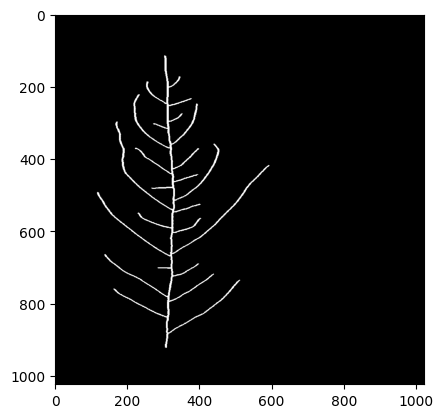

In [36]:
if len(decoded_masks.shape) == 3:  # Shape (batch_size, height, width)
    thresholded_predictions = (decoded_masks[1] > 0.5).astype(np.uint8)
    plt.imshow(thresholded_predictions, cmap='gray')
elif len(decoded_masks.shape) == 4:  # Shape (batch_size, height, width, channels)
    thresholded_predictions = (decoded_masks[1] > 0.5).astype(np.uint8)
    plt.imshow(thresholded_predictions[:, :, 0], cmap='gray')
else:
    raise ValueError("Unexpected shape of decoded_masks:", decoded_masks.shape)


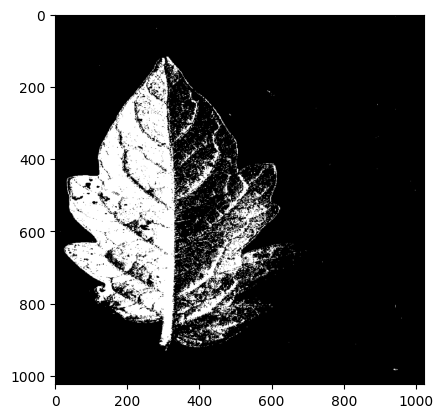

In [37]:

if len(images.shape) == 3:  # Shape (batch_size, height, width)
    thresholded_predictions = (images[1] > 0.5).astype(np.uint8)
    plt.imshow(thresholded_predictions, cmap='gray')
elif len(images.shape) == 4:  # Shape (batch_size, height, width, channels)
    thresholded_predictions = (images[1] > 0.5).astype(np.uint8)
    plt.imshow(thresholded_predictions[:, :, 0], cmap='gray')
else:
    raise ValueError("Unexpected shape of decoded_masks:", decoded_masks.shape)

In [38]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_val, y_train, y_val = train_test_split(images, decoded_masks, test_size=0.2, random_state=42)

# Fit U-Net
#model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=8)

In [39]:
def unet_for_leaf(input_shape=(1024, 1024, 3)):
    # Sequential-like layers for U-Net
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))

    # Encoder
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    # Bottleneck
    model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))

    # Decoder
    model.add(tf.keras.layers.UpSampling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))

    model.add(tf.keras.layers.UpSampling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))

    model.add(tf.keras.layers.UpSampling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))

    model.add(tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid'))

    return model

input_shape = (1024, 1024, 3)
unet_model = unet_for_leaf(input_shape)
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryIoU()])
unet_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 1024, 1024, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 1024, 1024, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 512, 512, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 512, 512, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 512, 512, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 256, 256, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 256, 256, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 256, 256, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 128, 128, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 128, 128, 512)       │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 128, 128, 512)       │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 256, 256, 512)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 256, 256, 256)       │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 256, 256, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 512, 512, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 512, 512, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 512, 512, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 1024, 1024, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 1024, 1024, 64)      │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 1024, 1024, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 1024, 1024, 1)       │              65 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 7,008,769 (26.74 MB)

 Trainable params: 7,008,769 (26.74 MB)

 Non-trainable params: 0 (0.00 B)

In [99]:
# New implementation
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.optimizers import RMSprop
def get_unet_1024(input_shape=(1024, 1024, 3),
                  num_classes=1):
    inputs = Input(shape=input_shape)
    # 1024

    down0b = Conv2D(16, (3, 3), padding='same')(inputs)
    down0b = BatchNormalization()(down0b)
    down0b = Activation('relu')(down0b)
    down0b = Conv2D(16, (3, 3), padding='same')(down0b)
    down0b = BatchNormalization()(down0b)
    down0b = Activation('relu')(down0b)
    down0b_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0b)
    # 512

    down0a = Conv2D(32, (3, 3), padding='same')(down0b_pool)
    down0a = BatchNormalization()(down0a)
    down0a = Activation('relu')(down0a)
    down0a = Conv2D(32, (3, 3), padding='same')(down0a)
    down0a = BatchNormalization()(down0a)
    down0a = Activation('relu')(down0a)
    down0a_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0a)
    # 256

    down0 = Conv2D(64, (3, 3), padding='same')(down0a_pool)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0 = Conv2D(64, (3, 3), padding='same')(down0)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0)
    # 128

    down1 = Conv2D(128, (3, 3), padding='same')(down0_pool)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(128, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    # 64

    down2 = Conv2D(256, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(256, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
    # 32

    down3 = Conv2D(512, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(512, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
    # 16

    down4 = Conv2D(1024, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(1024, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
    # 8

    center = Conv2D(2048, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(2048, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    # center

    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(1024, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(1024, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(1024, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    # 16

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(512, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(512, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(512, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    # 32

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(256, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(256, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(256, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    # 64

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(128, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(128, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(128, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    # 128

    up0 = UpSampling2D((2, 2))(up1)
    up0 = concatenate([down0, up0], axis=3)
    up0 = Conv2D(64, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(64, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(64, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    # 256

    up0a = UpSampling2D((2, 2))(up0)
    up0a = concatenate([down0a, up0a], axis=3)
    up0a = Conv2D(32, (3, 3), padding='same')(up0a)
    up0a = BatchNormalization()(up0a)
    up0a = Activation('relu')(up0a)
    up0a = Conv2D(32, (3, 3), padding='same')(up0a)
    up0a = BatchNormalization()(up0a)
    up0a = Activation('relu')(up0a)
    up0a = Conv2D(32, (3, 3), padding='same')(up0a)
    up0a = BatchNormalization()(up0a)
    up0a = Activation('relu')(up0a)
    # 512

    up0b = UpSampling2D((2, 2))(up0a)
    up0b = concatenate([down0b, up0b], axis=3)
    up0b = Conv2D(16, (3, 3), padding='same')(up0b)
    up0b = BatchNormalization()(up0b)
    up0b = Activation('relu')(up0b)
    up0b = Conv2D(16, (3, 3), padding='same')(up0b)
    up0b = BatchNormalization()(up0b)
    up0b = Activation('relu')(up0b)
    up0b = Conv2D(16, (3, 3), padding='same')(up0b)
    up0b = BatchNormalization()(up0b)
    up0b = Activation('relu')(up0b)
    # 1024

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up0b)

    model = Model(inputs=inputs, outputs=classify)

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[tf.keras.metrics.BinaryIoU()])

    return model

input_shape = (1024, 1024, 3)
unet_model = get_unet_1024(input_shape)
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryIoU()])
unet_model.summary()

Model: "functional_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 1024, 1024, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_106 (Conv2D)       │ (None, 1024, 1024, 16) │            448 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_74    │ (None, 1024, 1024, 16) │             64 │ conv2d_106[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_74             │ (None, 1024, 1024, 16) │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_107 (Conv2D)       │ (None, 1024, 1024, 16) │          2,320 │ activation_74[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_75    │ (None, 1024, 1024, 16) │             64 │ conv2d_107[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_75             │ (None, 1024, 1024, 16) │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_20          │ (None, 512, 512, 16)   │              0 │ activation_75[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_108 (Conv2D)       │ (None, 512, 512, 32)   │          4,640 │ max_pooling2d_20[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_76    │ (None, 512, 512, 32)   │            128 │ conv2d_108[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_76             │ (None, 512, 512, 32)   │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_109 (Conv2D)       │ (None, 512, 512, 32)   │          9,248 │ activation_76[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_77    │ (None, 512, 512, 32)   │            128 │ conv2d_109[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_77             │ (None, 512, 512, 32)   │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_21     

 Total params: 138,477,617 (528.25 MB)

 Trainable params: 138,449,105 (528.14 MB)

 Non-trainable params: 28,512 (111.38 KB)

In [43]:
class StopAndTestCallback(tf.keras.callbacks.Callback):
    def __init__(self, stop_epoch):
        super().__init__()
        self.stop_epoch = stop_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch + 1 == self.stop_epoch:
            print(f"\nStopping training at epoch {self.stop_epoch}")
            self.model.stop_training = True

In [13]:
#images=images[0]
#decoded_masks=decoded_masks[0]

In [100]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint.weights.h5',  # Save path
    save_best_only=True,            # Save the model at every epoch
    save_weights_only=True           # Save weights instead of the full model
)
stop_epoch = 300

model_main= unet_model.fit(images, decoded_masks,epochs=300,batch_size=1, verbose=1,callbacks=[checkpoint_callback,StopAndTestCallback(stop_epoch)])

Epoch 1/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 81s 316ms/step - binary_io_u_5: 0.4625 - loss: 0.3704
Epoch 2/300


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 314ms/step - binary_io_u_5: 0.4957 - loss: 0.1917
Epoch 3/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 323ms/step - binary_io_u_5: 0.4912 - loss: 0.1503
Epoch 4/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 322ms/step - binary_io_u_5: 0.4914 - loss: 0.1286
Epoch 5/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 332ms/step - binary_io_u_5: 0.4967 - loss: 0.1152
Epoch 6/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 325ms/step - binary_io_u_5: 0.4944 - loss: 0.1035
Epoch 7/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - binary_io_u_5: 0.5004 - loss: 0.0954
Epoch 8/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 317ms/step - binary_io_u_5: 0.5272 - loss: 0.0875
Epoch 9/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - binary_io_u_5: 0.5015 - loss: 0.0826
Epoch 10/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 319ms/step - binary_io_u_5: 0.5375 - loss: 0.0779
Epoch 11/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 317ms/step - binary_io_u_5: 0.5433 - loss: 0.0725
Epoch 12/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 321ms/step - binary_io_u_5: 0.5067 - l

(2, 1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
(1024, 1024, 1)


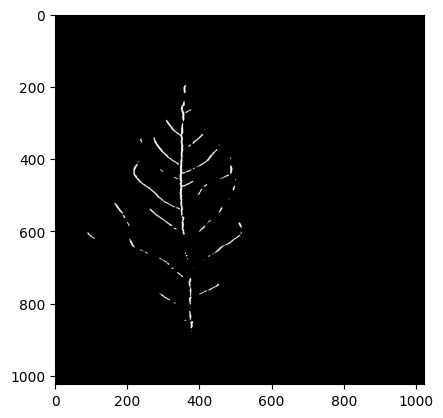

In [102]:
image_dir = "drive/MyDrive/Data/infected-tomato-leaf-vein-segmentation/single"
img_size = (1024, 1024)  # Input size for U-Net

images_test = load_images(image_dir, img_size)


print(images_test.shape)  # Should be (1, 1024, 1024, 3) for a single image

predictions = unet_model.predict(images_test)

print(predictions[0].shape)  # Should be (1, 875, 1400, 3) for a single image

reshaped_predictions = predictions[0][:, :, 0]  # Remove the batch and channel dimensions
np.savetxt('predictions.txt', reshaped_predictions)

thresholded_predictions = (predictions[1] > 0.5).astype(np.uint8)


import matplotlib.pyplot as plt

plt.imshow(thresholded_predictions[:, :, 0], cmap='gray')  # For binary segmentation
plt.show()


In [103]:
print(predictions.shape)

reshaped_predictions = predictions[0, :, :, 0]  # Remove the batch and channel dimensions
np.savetxt('predictions.txt', reshaped_predictions)

(2, 1024, 1024, 1)


In [104]:
# Save the entire model (architecture, weights, optimizer)
unet_model.save('unet_model_epoch2.h5')  # You can use any name for the file


In [105]:
# Function to perform Run-Length Encoding
def run_length_encode(mask):
    # Flatten the 2D mask into a 1D array
    flat_mask = mask.flatten()

    # Initialize the result list to store the RLE encoding
    rle = []

    # Initialize the first character of the string and the count
    prev_char = flat_mask[0]
    count = 1

    # Iterate through the flattened mask starting from the second character
    for char in flat_mask[1:]:
        if char == prev_char:
            # If the character is the same as the previous one, increment the count
            count += 1
        else:
            # If the character changes, append the previous character's count and value to the result
            rle.append(count)
            rle.append(prev_char)
            # Reset the count for the new character
            prev_char = char
            count = 1

    # Append the last character's count and value
    rle.append(count)
    rle.append(prev_char)

    # Return the RLE encoded result as a space-separated string
    return ' '.join(map(str, rle))
# Function to preprocess the test image
def preprocess_image(img_path, target_size=(1024, 1024)):
    """Load and preprocess the image."""
    img = cv2.imread(img_path)
    img = cv2.resize(img, target_size)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize the image
    return img

# Path to the test folder containing images
test_folder = 'drive/MyDrive/Data/infected-tomato-leaf-vein-segmentation/test'

# Prepare the submission dataframe
submission_data = []

# Iterate through all images in the test folder
for image_name in os.listdir(test_folder):
    if image_name.endswith(('.jpg', '.png')):  # Only process image files
        img_path = os.path.join(test_folder, image_name)

        # Preprocess the image
        img = preprocess_image(img_path)

        # Predict the mask using the model
        mask_prediction = unet_model.predict(img)
        mask = mask_prediction[0, :, :, 0]
        mask_resized = cv2.resize(mask, (875, 1400))
        # Since the output of the unet_model is a batch of masks, extract the first mask
        mask = (mask_resized> 0.5).astype(np.uint8)  # Binary mask, thresholding at 0.5
        reshaped_predictions = mask[:, :]  # Remove the batch and channel dimensions
        print(reshaped_predictions.shape)
        np.savetxt('predictions.txt', reshaped_predictions)

        # Apply RLE to the binary mask
        rle_encoded = run_length_encode(mask)

        # Append the result to the submission data
        image_id = image_name.split('.')[0]  # Extract the image ID without file extension
        submission_data.append([image_id, rle_encoded])

# Create a DataFrame for submission
submission_df = pd.DataFrame(submission_data, columns=['id', 'annotation'])

# Save the submission to a CSV file
submission_df.to_csv('submissionNew.csv', index=False)

print("Submission file created successfully!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
(1400, 875)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
(1400, 875)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
(1400, 875)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
(1400, 875)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(1400, 875)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
(1400, 875)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
(1400, 875)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
(1400, 875)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
(1400, 875)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
(1400, 875)
Submission file created successfully!
